In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.offline as py
from plotly.graph_objs import Scatter, Layout
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import sklearn as sk
import plotly.express as px
from dash import Dash, dcc, html, Input, Output  # pip install dash (version 2.0.0 or higher)
from flask import Flask
import dash_bootstrap_components as dbc
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [21]:
names = ['ID', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness', 'Impulsiveness', 'Sensation_seeking', 'Alcohol', 'Amphetamine', 'Amyl_nitrite', 'Benzodiazepine', 'Caffeine', 'Cannabis', 'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legal_highs', 'LSD', 'Methadone', 'Mushrooms', 'Nicotine', 'Semeron', 'VSA']
df = pd.read_csv('drug_consumption.data',delimiter=',', names=names)

In [22]:
#CL0 to CL6 correspond to
#"Never Used", "Used over a Decade Ago", "Used in Last Decade", "Used in Last Year", "Used in Last Month", "Used in Last Week", and "Used in Last Day".


# dictionnaire pour traduire les valeurs
traduction={-0.95197: "18-24 ans", -0.07854 :"25-34",  0.49788 :"35-44",1.09449 :"45-54", 1.82213:" 55-64", 2.59171: "65+"}
traduction[0.48246]="Female"
traduction[-0.48246]= "Male"
traduction[-2.43591 ]="Left school before 16 years"
traduction[-1.73790]= "Left school at 16 years"
traduction[-1.43719 ]="Left school at 17 years"
traduction[-1.22751]= "Left school at 18 years"
traduction[-0.61113]="Some college or university, no certificate or degree"
traduction[-0.05921]= "Professional certificate/ diploma "
traduction[0.45468]="University degree  "
traduction[1.16365]= "Masters degree "
traduction[1.98437]="Doctorate degree "

traduction[-0.09765 ]="Australia"
traduction[0.24923]= "Canada"
traduction[-0.46841]= "New Zealand "
traduction[-0.28519]= "Other "
traduction[0.21128]= "Republic of Ireland"
traduction[0.96082]= " UK "
traduction[-0.57009]= "USA"

traduction[-0.50212]="Asian"
traduction[-1.10702]="Black"
traduction[1.90725]="Mixed-Black/Asian"
traduction[0.12600]="Mixed-White/Asian"
traduction[-0.22166]="Mixed-White/Black"
traduction[0.11440]="Other "
traduction[-0.31685]="White"

traduction["CL0"]="Never Used"
traduction["CL1"]="Used over a Decade Ago"
traduction["CL2"]="Used in Last Decade"
traduction["CL3"]="Used in Last Year "
traduction["CL4"]="Used in Last Month"
traduction["CL5"]="Used in Last Week"
traduction["CL6"]="Used in Last Day"
        

In [23]:
df=df.set_index('ID')

## Visualisation 

In [24]:
liars = df[df['Semeron']!='CL0']
df.drop(df[df['Semeron']!='CL0'].index, inplace=True)
df.drop('Semeron', axis=1, inplace=True)

In [40]:
drugs = [ 'Alcohol', 'Amphetamine', 'Amyl_nitrite', 'Benzodiazepine', 'Caffeine', 'Cannabis', 
         'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legal_highs', 'LSD', 
         'Methadone', 'Mushrooms', 'Nicotine', 'VSA']

def change(a):
    if a in ['CL6', 'CL5', 'CL4']:
        return 2 #Regular users
    elif a in ['CL1', 'CL2', 'CL3']:
        return 1 #Occasional users
    elif a=='CL0':
        return 0 #Never used
    return a

df2=df.copy() #for a better display on the views
for drug in drugs:
    liars[drug]=liars[drug].apply(change)
    df2[drug]=df2[drug].apply(change)
    
def getDrugScore(drugName):
    return df2[[drugName, 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness', 'Impulsiveness', 'Sensation_seeking']]

In [33]:
pie1=(liars[drugs]>0).sum()
pie2=(df2[drugs]>0).sum()
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'pie'}, {'type': 'pie'}]],
                    subplot_titles=['Drug repartition for liars', 'Drug repartition for people'])
fig.add_trace(go.Pie(values=pie1.values,labels=pie1.index, name=""), row=1, col=1)
fig.add_trace(go.Pie(values=pie2.values,labels=pie2.index, name=""), row=1, col=2)
fig.show()

In [32]:
fig = px.bar(df2[drugs].apply(lambda x: x.value_counts()).T.rename(columns={0:'Never Used',1:'Occasional', 2:'Regular'}),
       barmode='group',
       title='Distribution of the number of users for each drug'
      )
fig.update_layout(title_x=0.5)
fig.show()

In [31]:
fig = px.imshow(df.corr())
fig.update_layout(title='Correlation Matrix of DataFrame Columns',
                  title_x=0.5, width=800, height=800, coloraxis_colorbar={'title':'Correlation'})
fig.show()

In [29]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=len(drugs), cols=1, subplot_titles=drugs)

for i, drug in enumerate(drugs):
    data = getDrugScore(drug)
    subplot = px.bar(data.groupby(drug).mean().T.rename(columns={0:"Occasional", 1:'Regular'}), barmode='group')
    for trace in range(len(subplot["data"])):
        fig.append_trace(subplot["data"][trace], row=i+1, col=1)
    

fig.update_layout(height=200*len(drugs), width=600, title_text="Mean score for each drug")
fig.show()

In [30]:
fig = make_subplots(rows=len(drugs), cols=2, 
                    specs=[[{'type': 'pie'}, {'type': 'pie'}]]*len(drugs), #specify the type of each subplot
                    subplot_titles=[f'{drug} -{a}' for drug in drugs for a in ['Man', 'Woman']] #add a title to each subplot
                   )

for i, drug in enumerate(drugs):

    data1=df2[df2['Gender']==0.48246].replace(traduction)[drug].value_counts().rename(index={0:'Occasional', 1:'Regular'})
    #count each value (0/1) for each drug, filtered by gender
    fig.append_trace(
        go.Pie(values=data1.values, labels=data1.index, name=""), #name="" : prevent from trace X to appear in the hover
        row=i+1, col=1
    )
    
    data2=df2[df2['Gender']==-0.48246].replace(traduction)[drug].value_counts().rename(index={0:'Occasional', 1:'Regular'})
    fig.append_trace(
        go.Pie(values=data2.values, labels=data2.index, name=""),
        row=i+1, col=2
    )

fig.update_layout(height=300*len(drugs), width=700, title_text='Gender repartition for each drug', title_x=0.5) #title_x : center the title
for annotation in fig['layout']['annotations']: 
    annotation['borderpad']=10 #put every subplot title higher to prevent overlapping with percentages
fig.show()

In [43]:
educ = df2['Education'].map(traduction).value_counts()
fig=go.Figure()
fig.add_trace(go.Pie(values=np.array(educ.values), labels=np.array(educ.index)))
fig.update_layout(title='Education level repartition of the people', title_x=0.19)
fig.show()

In [41]:
scores = ['Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness', 'Impulsiveness', 'Sensation_seeking']

data = pd.DataFrame()

for drug in drugs:
    # Calculate the mean for each score for the current drug
    data = pd.concat([data, df2[df2[drug] > 0][scores].mean().to_frame().T])

# Add a 'Drug' column to the DataFrame
data['Drug'] = drugs

# Reorder the columns to have 'Drug' as the first column
data = data[['Drug'] + scores]

In [42]:
fig = px.line(data, x='Drug', y=scores, title='Mean Scores for Each Drug',
              labels={'value': 'Mean Score', 'variable': 'Score'})
fig.update_layout(title_x=0.5)
fig.show()

# Machine Learning

In [7]:
def change(a):
    if a in ['CL6', 'CL5', 'CL4']:
        return 1
    elif a in ['CL0', 'CL1', 'CL2', 'CL3']:
        return 0
    return a

dff= df.applymap(change)
drug_columns = ['Ecstasy', 'Heroin', 'Ketamine', 'Legal_highs','LSD', 
                'Methadone', 'Mushrooms', 'Nicotine', 'Semeron', 'VSA']
X = dff.drop(drug_columns, axis=1)
y = dff[drug_columns]

numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

if len(numeric_cols) == 0:
    raise ValueError("No numeric columns found. Check your DataFrame.")

scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X[numeric_cols])

encoder = OneHotEncoder()
X_categorical_encoded = encoder.fit_transform(X[categorical_cols]).toarray()

X_processed = np.concatenate([X_numeric_scaled, X_categorical_encoded], axis=1)

X_tensor = torch.tensor(X_processed, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class DrugUseNet(nn.Module):
    def __init__(self, num_features):
        super(DrugUseNet, self).__init__()
        self.fc1 = nn.Linear(num_features, 128) 
        self.fc2 = nn.Linear(128, 64)           
        self.fc3 = nn.Linear(64, len(drug_columns)) 

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

model = DrugUseNet(X_tensor.shape[1])

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

epochs = 25

for epoch in range(epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

Epoch 1/25, Loss: 0.1539495438337326
Epoch 2/25, Loss: 0.18997466564178467
Epoch 3/25, Loss: 0.214040145277977
Epoch 4/25, Loss: 0.2489873617887497
Epoch 5/25, Loss: 0.2514279782772064
Epoch 6/25, Loss: 0.17657330632209778
Epoch 7/25, Loss: 0.19160950183868408
Epoch 8/25, Loss: 0.19619672000408173
Epoch 9/25, Loss: 0.21736177802085876
Epoch 10/25, Loss: 0.23321011662483215
Epoch 11/25, Loss: 0.2455754280090332
Epoch 12/25, Loss: 0.15356957912445068
Epoch 13/25, Loss: 0.12871983647346497
Epoch 14/25, Loss: 0.23823747038841248
Epoch 15/25, Loss: 0.1589716672897339
Epoch 16/25, Loss: 0.2675863206386566
Epoch 17/25, Loss: 0.21050402522087097
Epoch 18/25, Loss: 0.17551419138908386
Epoch 19/25, Loss: 0.21138356626033783
Epoch 20/25, Loss: 0.23717306554317474
Epoch 21/25, Loss: 0.21313174068927765
Epoch 22/25, Loss: 0.16462968289852142
Epoch 23/25, Loss: 0.290903240442276
Epoch 24/25, Loss: 0.14311304688453674
Epoch 25/25, Loss: 0.13980929553508759


Epoch 1/25, Loss: 0.139272078871727
Epoch 2/25, Loss: 0.1634170562028885
Epoch 3/25, Loss: 0.16602469980716705
Epoch 4/25, Loss: 0.12451232224702835
Epoch 5/25, Loss: 0.1519053727388382
Epoch 6/25, Loss: 0.14741460978984833
Epoch 7/25, Loss: 0.17487424612045288
Epoch 8/25, Loss: 0.13660569489002228
Epoch 9/25, Loss: 0.17916245758533478
Epoch 10/25, Loss: 0.13798484206199646
Epoch 11/25, Loss: 0.16970504820346832
Epoch 12/25, Loss: 0.12874196469783783
Epoch 13/25, Loss: 0.1742992103099823
Epoch 14/25, Loss: 0.15595242381095886
Epoch 15/25, Loss: 0.14876823127269745
Epoch 16/25, Loss: 0.16380077600479126
Epoch 17/25, Loss: 0.19803161919116974
Epoch 18/25, Loss: 0.1956413984298706
Epoch 19/25, Loss: 0.10634839534759521
Epoch 20/25, Loss: 0.20703446865081787
Epoch 21/25, Loss: 0.20986521244049072
Epoch 22/25, Loss: 0.1705351322889328
Epoch 23/25, Loss: 0.18781881034374237
Epoch 24/25, Loss: 0.17236770689487457
Epoch 25/25, Loss: 0.13774383068084717


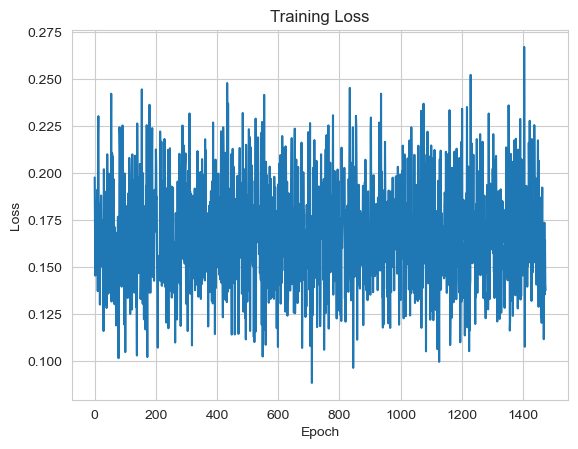

In [10]:
import matplotlib.pyplot as plt

losses = []
for epoch in range(epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        losses.append(loss.item())

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

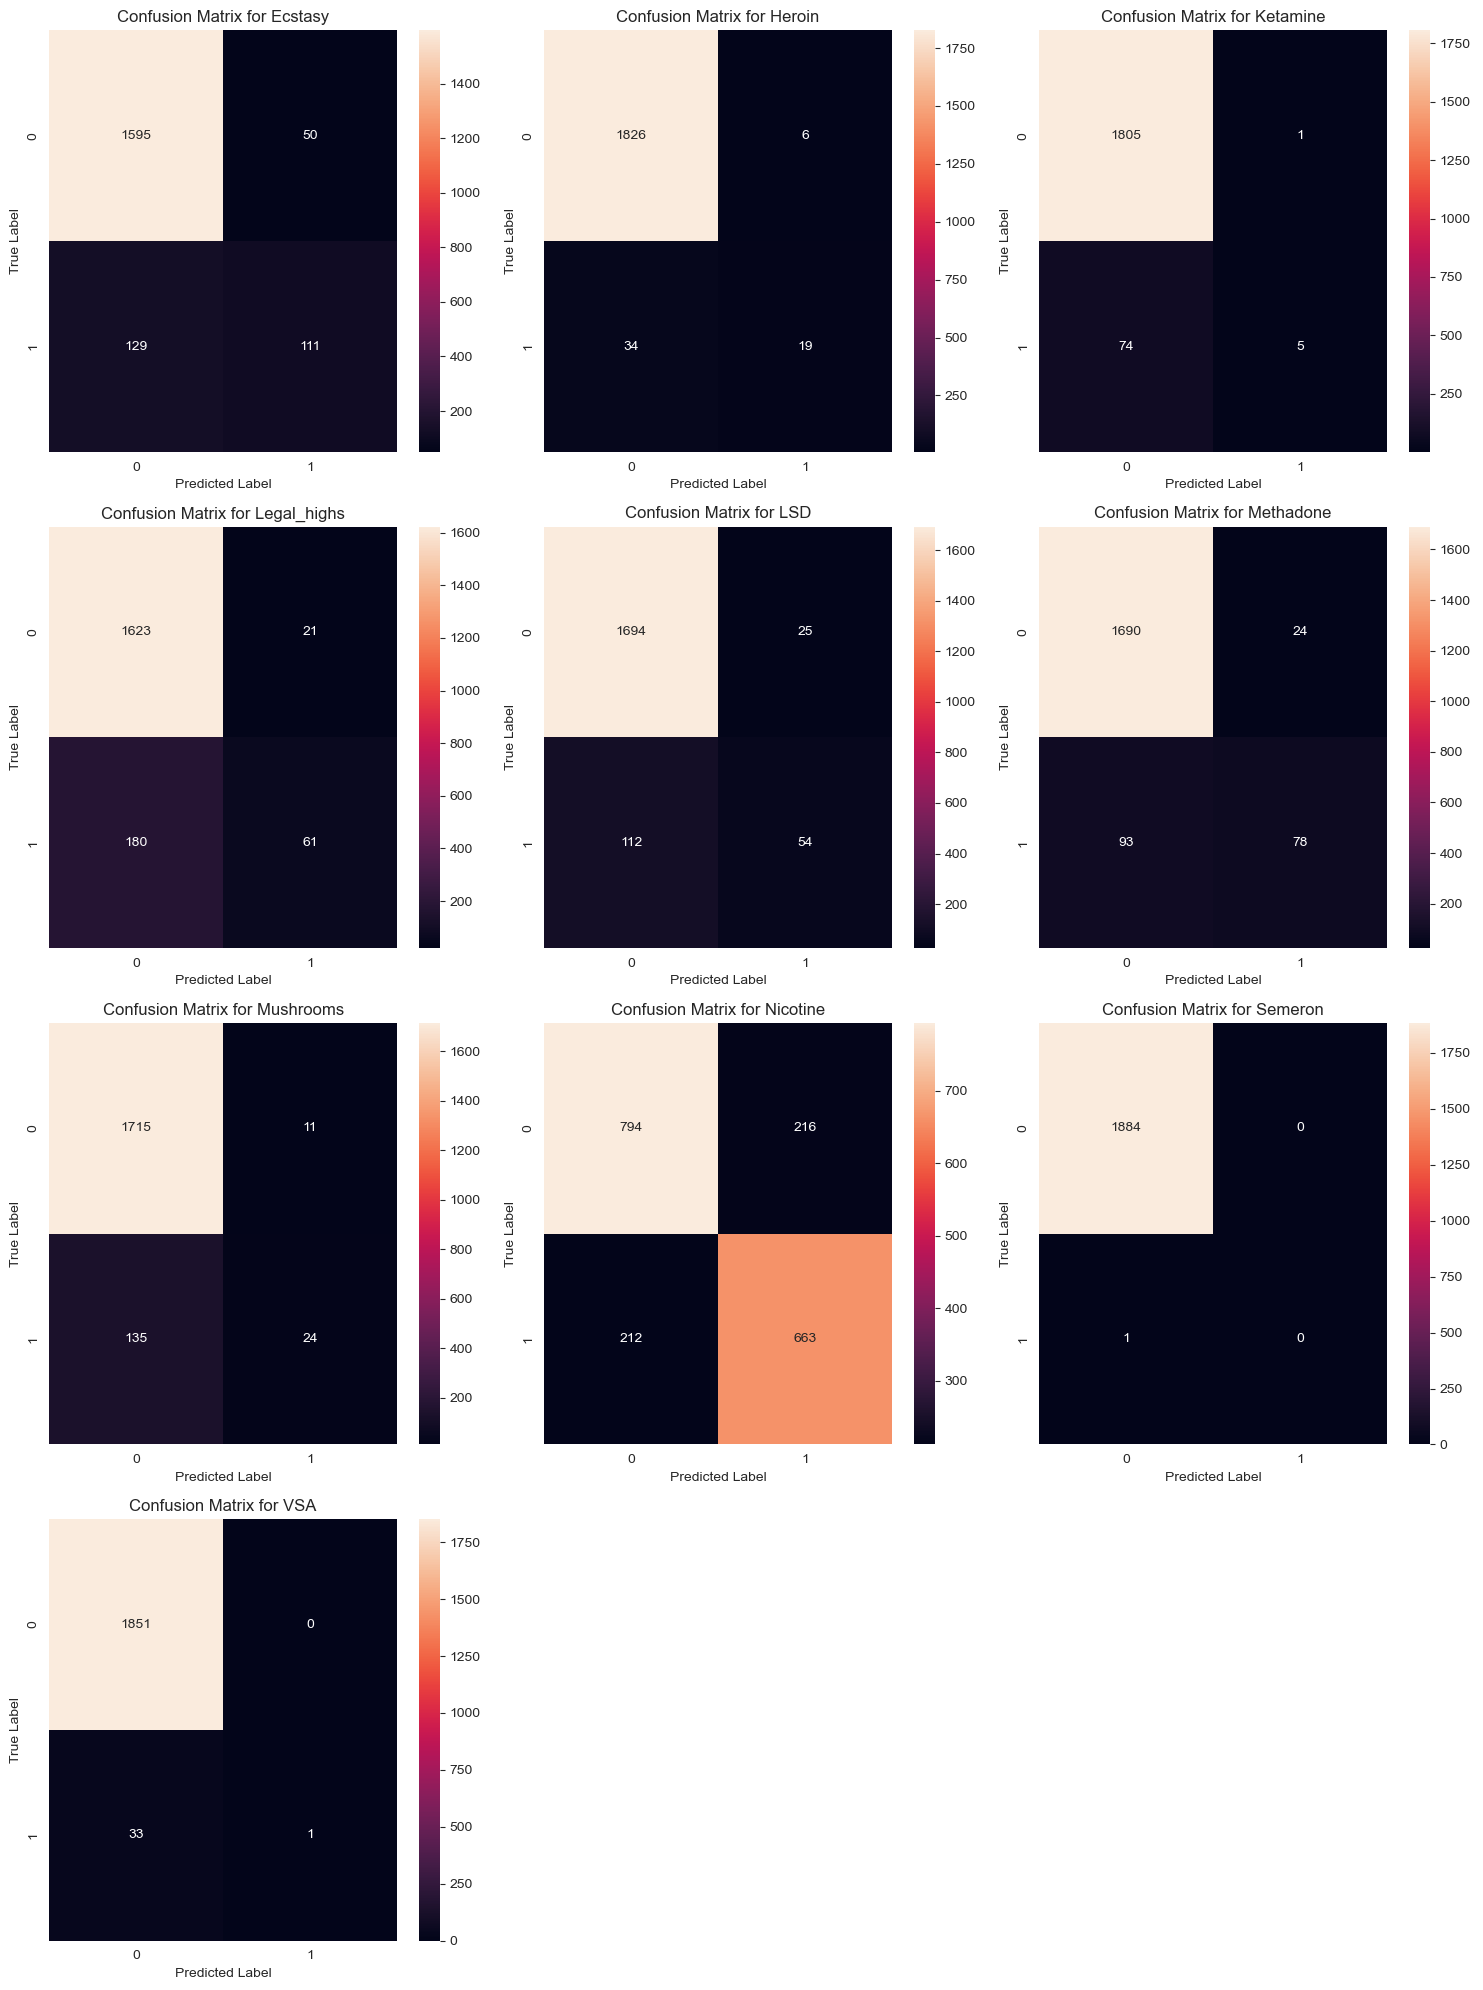

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

num_drugs = len(drug_columns)

num_rows = int(np.ceil(num_drugs / 3)) 
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

model.eval()  
with torch.no_grad():
    predictions = model(X_tensor)
    predicted_labels = predictions.round() 

for i, ax in enumerate(axes.flatten()):
    if i < num_drugs:
        true_labels = y_tensor[:, i]
        pred_labels = predicted_labels[:, i]
        cm = confusion_matrix(true_labels, pred_labels)
        sns.heatmap(cm, annot=True, fmt='d', ax=ax)
        ax.set_title(f'Confusion Matrix for {drug_columns[i]}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
    else:
        ax.axis('off')  

plt.tight_layout()
plt.show()

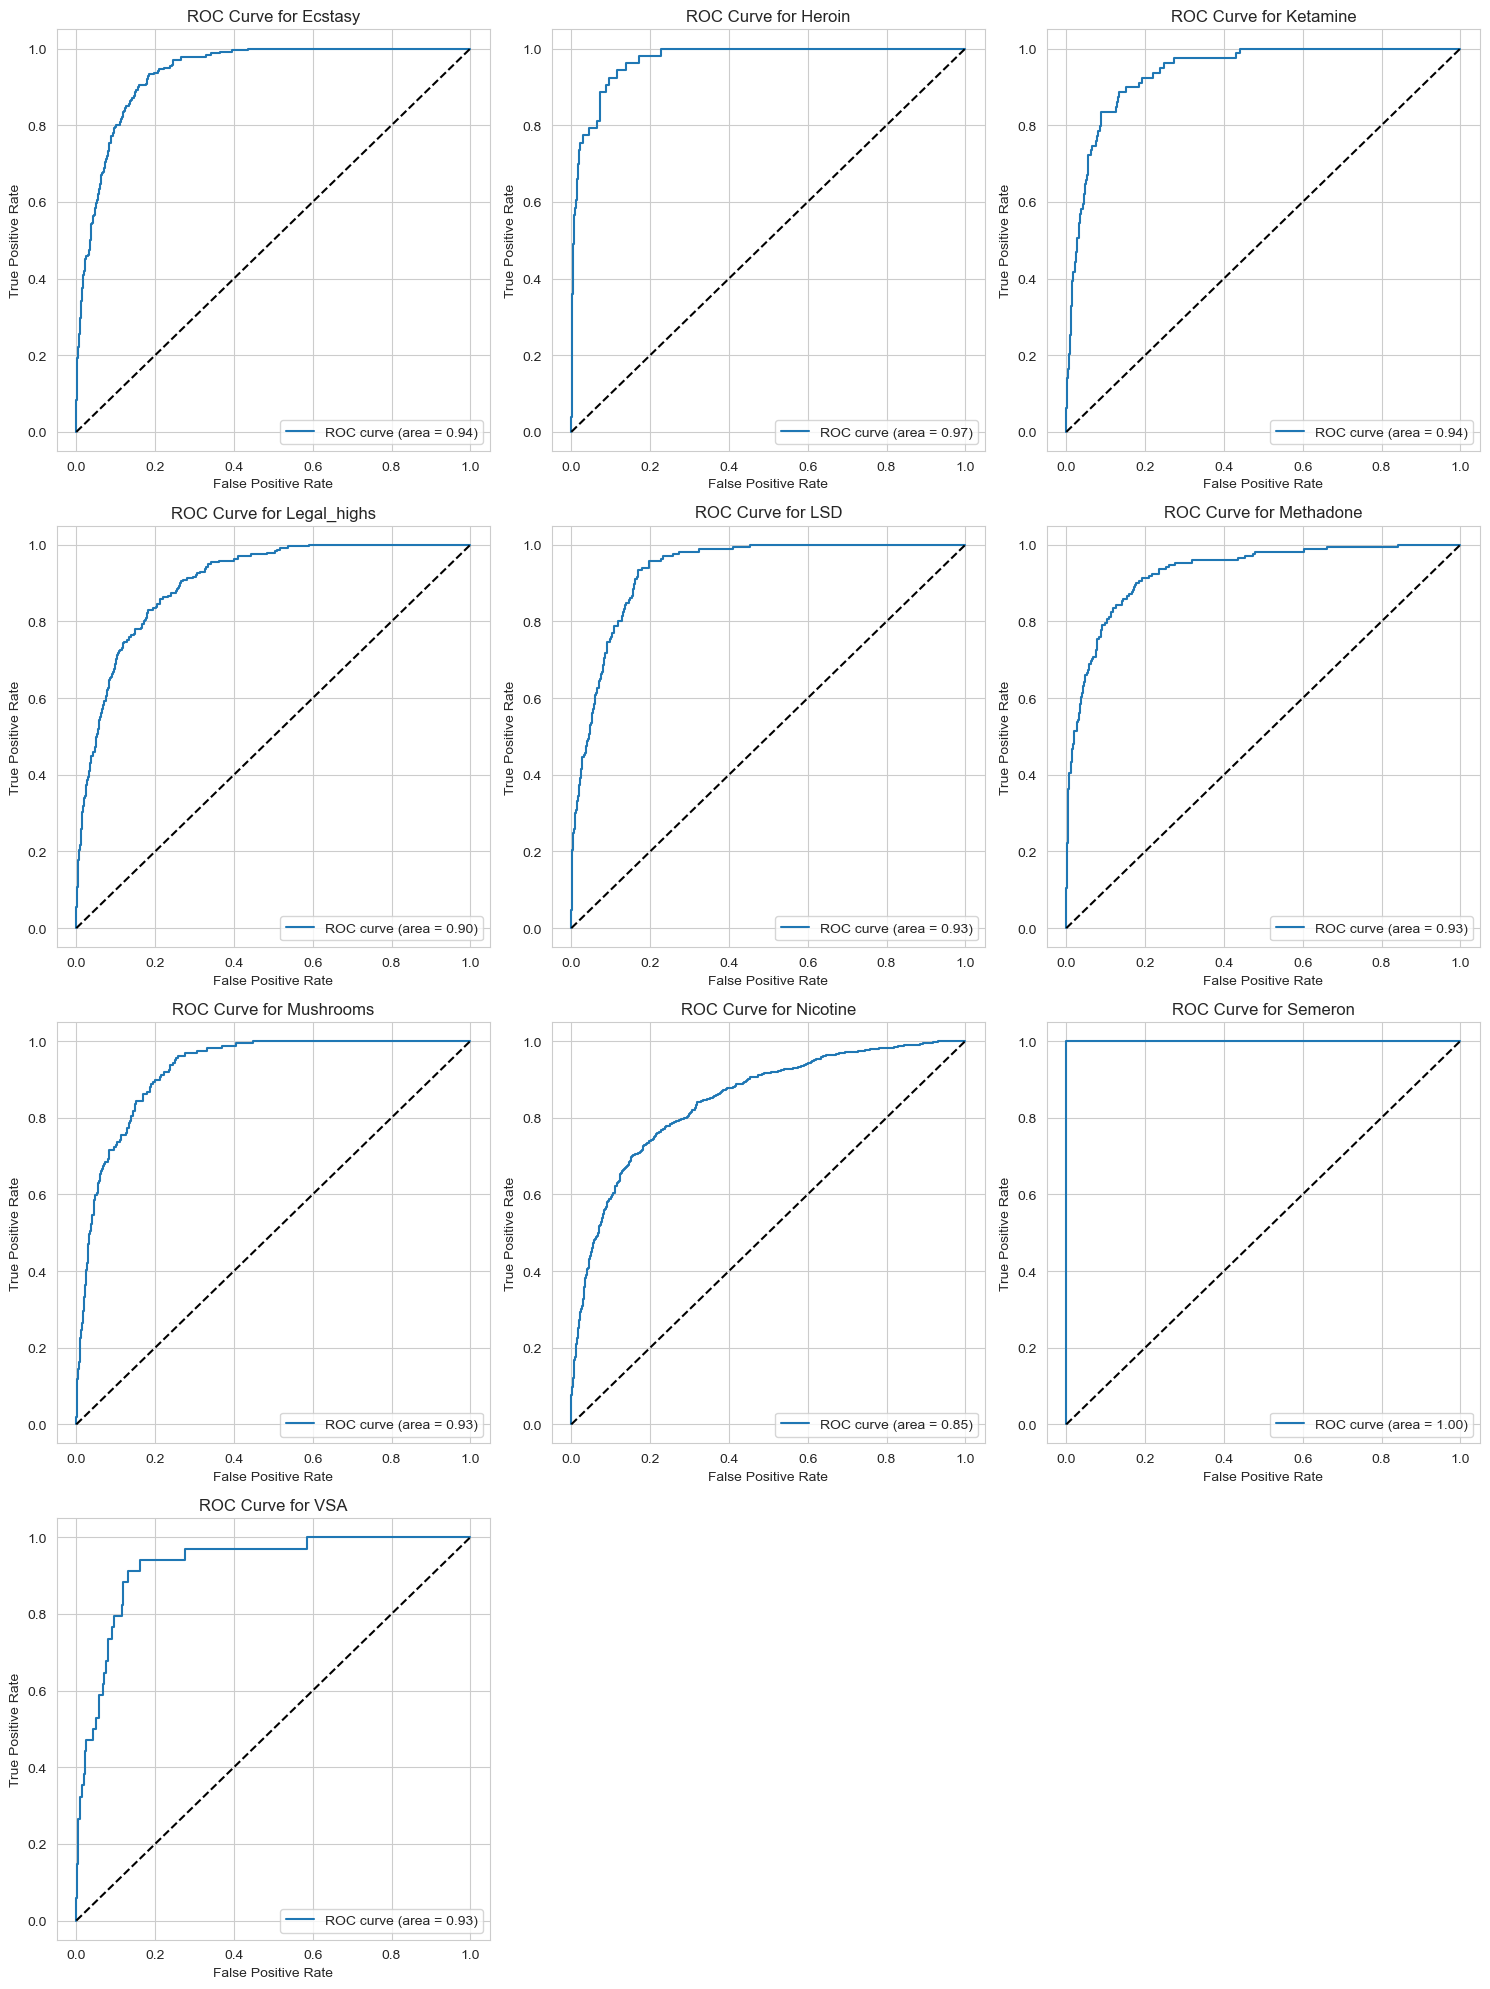

In [12]:
from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

for i, ax in enumerate(axes.flatten()):
    if i < num_drugs:
        true_labels = y_tensor[:, i]
        pred_probs = predictions[:, i]
        fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        ax.plot([0, 1], [0, 1], 'k--') 
        ax.set_title(f'ROC Curve for {drug_columns[i]}')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc="lower right")
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


We will compare the following models:
1. Logistic Regression - A good baseline for classification problems.
2. Random Forest - An ensemble method known for its high accuracy.
3. Support Vector Machine (SVM) - Effective in high dimensional spaces.



Hyperparameters we will tune:
- Logistic Regression: Regularization strength (`C`)
- Random Forest: Number of trees (`n_estimators`) and max depth of trees (`max_depth`)
- SVM: Regularization parameter (`C`) and kernel type (`kernel`)


# Logistic Regression

In [14]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model_to_tune = OneVsRestClassifier(LogisticRegression())
param_grid = {'estimator__C': [0.1, 1, 10, 100]} 

clf = GridSearchCV(model_to_tune, param_grid, cv=5)
clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)

C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning:

Label not 8 is present in all training examples.

C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning:

Label not 8 is present in all training examples.

C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning:

Label not 8 is present in all training examples.

C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning:

Label not 8 is present in all training examples.



Best parameters: {'estimator__C': 0.1}
Best score: 0.4668610151591824


In [15]:
y_train_np = y_train.to_numpy() 

results = {}

for i, drug in enumerate(drug_columns):
    clf = GridSearchCV(LogisticRegression(max_iter = 1000), {'C': [0.1, 1, 10, 100]}, cv=5)
    clf.fit(X_train, y_train_np[:, i])  
    results[drug] = {
        'best_params': clf.best_params_,
        'best_score': clf.best_score_
    }

for drug, res in results.items():
    print(f"{drug}: Best Score - {res['best_score']}, Best Params - {res['best_params']}")

C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


4 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *arg

Ecstasy: Best Score - 0.8693604101119888, Best Params - {'C': 0.1}
Heroin: Best Score - 0.9741413830278762, Best Params - {'C': 0.1}
Ketamine: Best Score - 0.9615365998547887, Best Params - {'C': 0.1}
Legal_highs: Best Score - 0.8826252447690921, Best Params - {'C': 0.1}
LSD: Best Score - 0.9091549140832985, Best Params - {'C': 0.1}
Methadone: Best Score - 0.9078260104288134, Best Params - {'C': 0.1}
Mushrooms: Best Score - 0.9190974896041892, Best Params - {'C': 0.1}
Nicotine: Best Score - 0.7062506875536292, Best Params - {'C': 0.1}
Semeron: Best Score - nan, Best Params - {'C': 0.1}
VSA: Best Score - 0.9840861587203802, Best Params - {'C': 0.1}


In [16]:

encoder = OneHotEncoder()
X_categorical_encoded = encoder.fit_transform(X[categorical_cols]).toarray()


X_processed = np.concatenate([X_numeric_scaled, X_categorical_encoded], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


subset_size = 0.3
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-subset_size, random_state=42)
X_test_subset, _, y_test_subset, _ = train_test_split(X_test, y_test, test_size=1-subset_size, random_state=42)


y_train_subset = y_train_subset.to_numpy()
y_test_subset = y_test_subset.to_numpy()



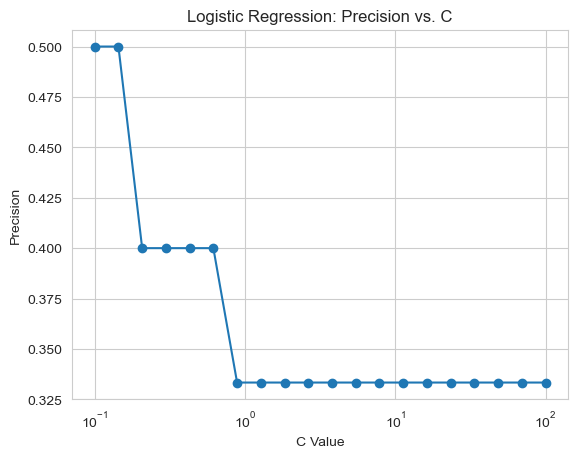

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
import numpy as np
import matplotlib.pyplot as plt

C_values = np.logspace(-1, 2, 20) 
precisions = []

for C in C_values:
    model = LogisticRegression(C=C, max_iter=500)
    model.fit(X_train_subset, y_train_subset[:, 0])
    predictions = model.predict(X_test_subset)
    precision = precision_score(y_test_subset[:, 0], predictions, zero_division=0)
    precisions.append(precision)

plt.plot(C_values, precisions, marker='o')
plt.xlabel('C Value')
plt.ylabel('Precision')
plt.title('Logistic Regression: Precision vs. C')
plt.xscale('log')
plt.show()


The output from the Logistic Regression model suggests varied performance across different drugs. Notably, drugs like 'Heroin', 'Ketamine', and 'VSA' achieve high scores, indicating effective predictive capability. Conversely, drugs such as 'Ecstasy' and 'Nicotine' yield lower scores, suggesting a more complex relationship with the features or a less distinct usage pattern. The variation in the optimal regularization strength (C) further highlights the unique nature of each drug's relationship with the predictors.

Key Takeaways:

Performance Variation: The model's effectiveness varies significantly across different drugs.
Regularization Strength: Optimal C values differ for each drug, underlining the need for tailored model configurations.
Data Specificity: The results emphasize the importance of considering each drug independently due to varying influences on usage patterns.

# Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10]}
rf_results = {}

for i, drug in enumerate(drug_columns):
    clf = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)
    clf.fit(X_train, y_train_np[:, i])
    rf_results[drug] = {
        'best_params': clf.best_params_,
        'best_score': clf.best_score_
    }

for drug, res in rf_results.items():
    print(f"{drug} - RF: Best Score - {res['best_score']}, Best Params - {res['best_params']}")

C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



Ecstasy - RF: Best Score - 0.8746584233570219, Best Params - {'max_depth': 10, 'n_estimators': 50}
Heroin - RF: Best Score - 0.972812479373391, Best Params - {'max_depth': 5, 'n_estimators': 10}
Ketamine - RF: Best Score - 0.9608765483707729, Best Params - {'max_depth': None, 'n_estimators': 10}
Legal_highs - RF: Best Score - 0.8760005280411873, Best Params - {'max_depth': 10, 'n_estimators': 10}
LSD - RF: Best Score - 0.9118061208774284, Best Params - {'max_depth': 5, 'n_estimators': 10}
Methadone - RF: Best Score - 0.9111438692217992, Best Params - {'max_depth': None, 'n_estimators': 50}
Mushrooms - RF: Best Score - 0.9204263932586741, Best Params - {'max_depth': 5, 'n_estimators': 10}
Nicotine - RF: Best Score - 0.7095641460033881, Best Params - {'max_depth': 5, 'n_estimators': 50}
Semeron - RF: Best Score - 0.9993377483443708, Best Params - {'max_depth': None, 'n_estimators': 10}
VSA - RF: Best Score - 0.9840861587203802, Best Params - {'max_depth': None, 'n_estimators': 10}


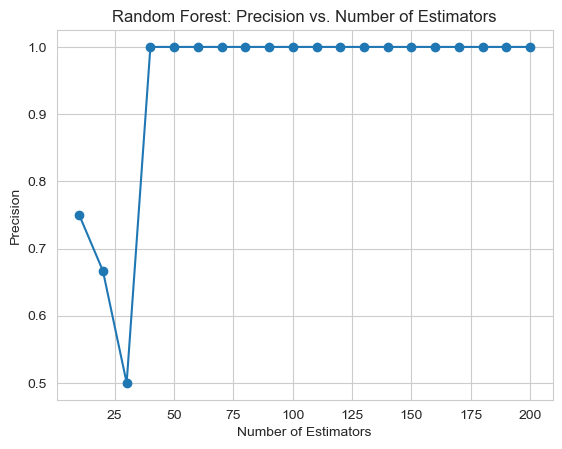

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import numpy as np

n_estimators_values = np.arange(10, 210, 10)
rf_precisions = []

for n_estimators in n_estimators_values:
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_model.fit(X_train_subset, y_train_subset[:, 0])
    predictions = rf_model.predict(X_test_subset)
    precision = precision_score(y_test_subset[:, 0], predictions, zero_division=0)
    rf_precisions.append(precision)

plt.plot(n_estimators_values, rf_precisions, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Precision')
plt.title('Random Forest: Precision vs. Number of Estimators')
plt.show()


The Random Forest model, known for its robustness and ability to handle complex interactions, also shows variability in performance across different drugs. This model performs exceptionally well for drugs like 'Heroin', 'VSA', and 'Mushrooms', while showing moderate performance for others like 'Nicotine'. The variation in the best parameters (n_estimators and max_depth) across different drugs reinforces the idea that each drug's usage pattern is influenced by different factors.

Key Observations:

High Accuracy for Certain Drugs: 'Heroin', 'VSA', and 'Mushrooms' show notably high prediction accuracy.
Parameter Variation: The best parameters for Random Forest vary, indicating the model's adaptability to different data structures.
Model Robustness: Random Forest's ability to capture complex patterns is evident in its generally high scores.

# Support Vector Machine

In [20]:
from sklearn.svm import SVC

svm_params = {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']}
svm_results = {}

for i, drug in enumerate(drug_columns):
    clf = GridSearchCV(SVC(), svm_params, cv=5)
    clf.fit(X_train, y_train_np[:, i])
    svm_results[drug] = {
        'best_params': clf.best_params_,
        'best_score': clf.best_score_
    }

for drug, res in svm_results.items():
    print(f"{drug} - SVM: Best Score - {res['best_score']}, Best Params - {res['best_params']}")

C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *arg

Ecstasy - SVM: Best Score - 0.8779740819783944, Best Params - {'C': 1, 'kernel': 'rbf'}
Heroin - SVM: Best Score - 0.972812479373391, Best Params - {'C': 0.1, 'kernel': 'rbf'}
Ketamine - SVM: Best Score - 0.9608765483707729, Best Params - {'C': 0.1, 'kernel': 'rbf'}
Legal_highs - SVM: Best Score - 0.8740049723878462, Best Params - {'C': 0.1, 'kernel': 'rbf'}
LSD - SVM: Best Score - 0.9118061208774284, Best Params - {'C': 0.1, 'kernel': 'rbf'}
Methadone - SVM: Best Score - 0.9098149655673142, Best Params - {'C': 0.1, 'kernel': 'rbf'}
Mushrooms - SVM: Best Score - 0.9197619414314318, Best Params - {'C': 0.1, 'kernel': 'rbf'}
Nicotine - SVM: Best Score - 0.7088974940045324, Best Params - {'C': 1, 'kernel': 'rbf'}
Semeron - SVM: Best Score - nan, Best Params - {'C': 0.1, 'kernel': 'rbf'}
VSA - SVM: Best Score - 0.9840861587203802, Best Params - {'C': 0.1, 'kernel': 'rbf'}


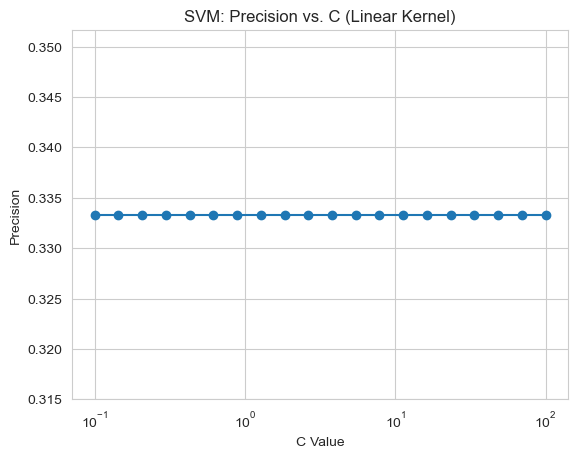

In [21]:
from sklearn.svm import SVC

C_values_svm = np.logspace(-1, 2, 20)  
svm_precisions = []

for C in C_values_svm:
    svm_model = SVC(C=C, kernel='linear', random_state=42) 
    svm_model.fit(X_train_subset, y_train_subset[:, 0])
    predictions = svm_model.predict(X_test_subset)
    precision = precision_score(y_test_subset[:, 0], predictions, zero_division=0)
    svm_precisions.append(precision)

plt.plot(C_values_svm, svm_precisions, marker='o')
plt.xlabel('C Value')
plt.ylabel('Precision')
plt.title('SVM: Precision vs. C (Linear Kernel)')
plt.xscale('log')
plt.show()

The SVM model, effective in high-dimensional spaces, displays a mixed performance similar to the previous models. It achieves high accuracy for drugs like 'Heroin' and 'VSA', while other drugs show varied results. The choice of kernel and C value differs across drugs, indicating the need for specific tuning for each drug's prediction.

Insights:

Effective High-Dimensional Learning: The SVM model works well for certain drugs, especially where linear separability might be present (as indicated by the success of the 'linear' kernel in some cases).
Kernel and Regularization: The choice of kernel and C value significantly impacts model performance, requiring careful tuning for each drug.
Balanced Performance: While not always achieving the highest scores, SVM provides a balanced performance across different drugs.
In summary, the comparison of Logistic Regression, Random Forest, and SVM models on this multi-label drug consumption dataset reveals significant variations in performance across different drugs. Each model has its strengths and is better suited for predicting certain drugs over others. The analysis suggests the necessity of a tailored approach for each drug, considering the unique patterns and relationships within the data.

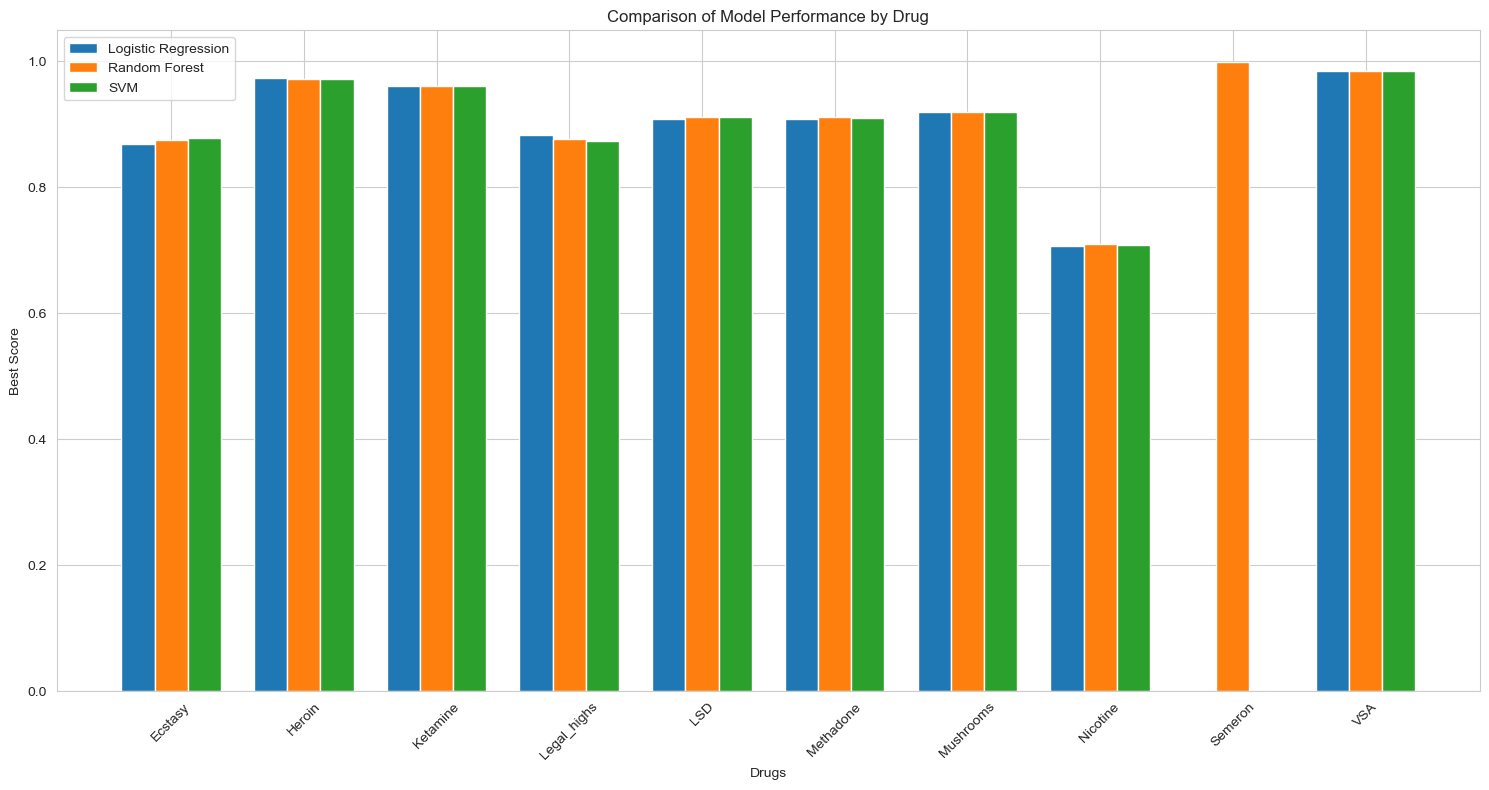

In [22]:
import matplotlib.pyplot as plt
import numpy as np

drugs = list(drug_columns)
scores_lr = [results[drug]['best_score'] for drug in drugs]
scores_rf = [rf_results[drug]['best_score'] for drug in drugs]
scores_svm = [svm_results[drug]['best_score'] for drug in drugs]

bar_width = 0.25
index = np.arange(len(drugs))

plt.figure(figsize=(15, 8))

plt.bar(index, scores_lr, bar_width, label='Logistic Regression')
plt.bar(index + bar_width, scores_rf, bar_width, label='Random Forest')
plt.bar(index + 2*bar_width, scores_svm, bar_width, label='SVM')

plt.xlabel('Drugs')
plt.ylabel('Best Score')
plt.title('Comparison of Model Performance by Drug')
plt.xticks(index + bar_width, drugs, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
colors = {
    'background': '#111111',
    'text': '#7FDBFF'
}
def generate_table(dataframe, max_rows=10):
    # dataframe=dataframe.iloc[4:max_rows, 12:]
    # dataframe=dataframe.applymap(lambda i:traduction[i])
    return html.Div(
        style={'overflow-x': 'auto'},  # Ajout de la barre de défilement horizontale
        children=[
            html.Table(
                style={
                    'width': '80%',
                    'margin': 'auto',
                    'background-color': colors['background'],
                    'color': colors['text']
                },
                children=[
                    html.Thead(
                        html.Tr([html.Th(col) for col in dataframe.columns])
                    ),
                    html.Tbody([
                        html.Tr([
                            html.Td(dataframe.iloc[i][col]) for col in dataframe.columns
                        ]) for i in range(min(len(dataframe), max_rows))
                    ])
                ]
            )
        ]
    )

In [43]:
df.columns

Index(['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Neuroticism',
       'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness',
       'Impulsiveness', 'Sensation_seeking', 'Alcohol', 'Amphetamine',
       'Amyl_nitrite', 'Benzodiazepine', 'Caffeine', 'Cannabis', 'Chocolate',
       'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legal_highs',
       'LSD', 'Methadone', 'Mushrooms', 'Nicotine', 'Semeron', 'VSA'],
      dtype='object')

In [74]:
app = Dash(__name__)
external_stylesheets = [dbc.themes.CERULEAN]
app = Dash(__name__, external_stylesheets=external_stylesheets)
# App layout
app.layout = dbc.Container(children=[
    html.H1(
        children="Web Application Dashboards with Dash",
        style={'background-color': colors['background'],
        'color': colors['text']}
        ),

    dcc.Dropdown(id="slct_column",
                 options = [{"label": i, "value" :i} for i in df.columns],
                 multi=False,
                 value="Age",
                 style={
                'background-color': colors['background'],
                'color': colors['text'],
                'border': f'1px solid {colors["text"]}'  # Ajoute une bordure pour mieux distinguer le menu déroulant
    }
                 ),
    html.Br(), #espace
    dcc.Graph(id='count plot mgl', figure={}),
    dcc.Graph(id='covariance', figure={}),
    
    dbc.Row([html.P("Age"),
             dcc.Slider(0, 100, 5, value=50, id='age'),
             html.P("Neuroticism"),
             dcc.Slider(-3, 3, 0.3, value=0, id='Neuroticism'),
             html.P("Extraversion"),
             dcc.Slider(-3, 3, 0.3, value=0, id='Extraversion'),
             html.P("Openness"),
             dcc.Slider(-3, 3, 0.3, value=0, id='Openness'),
             html.P("Conscientiousness"),
             dcc.Slider(-3, 3, 0.3, value=0, id='Agreeableness'),
             html.P("Neuroticism"),
             dcc.Slider(-3, 3, 0.3, value=0, id='Conscientiousness'),
             html.P("Impulsiveness"),
             dcc.Slider(-3, 3, 0.3, value=0, id='Impulsiveness'),
             html.P("Sensation_seeking"),
             dcc.Slider(-2, 2, 0.2, value=0, id='Sensation_seeking')
    ]),
    html.Table([
        html.Tr([html.Th('Slider'), html.Th('Position')]),
        html.Tr([html.Td('Slider 1'), html.Td(id='slider1-output')]),
        html.Tr([html.Td('Slider 2'), html.Td(id='slider2-output')]),
        html.Tr([html.Td('Slider 3'), html.Td(id='slider3-output')]),
        html.Tr([html.Td('Slider 4'), html.Td(id='slider4-output')]),
        html.Tr([html.Td('Slider 5'), html.Td(id='slider5-output')]),
        html.Tr([html.Td('Slider 6'), html.Td(id='slider6-output')]),
        html.Tr([html.Td('Slider 7'), html.Td(id='slider7-output')]),
        html.Tr([html.Td('Slider 8'), html.Td(id='slider8-output')])
    ]),
    html.H4(children='Affichage du dataset', style={
    'background-color': colors['background'],
    'color': colors['text']}),
    generate_table(df)
],style={'background-color': colors['background'], 'color': colors['text']})

In [75]:
# Connect the Plotly graphs with Dash Components
@app.callback( #sous chaque callback, il y a une fonction update_graph, qui adapte le graph en fonction de l'imput
    [Output(component_id='count plot mgl', component_property='figure')],
    [Input(component_id='slct_column', component_property='value')]
)
def update_graph(option_slctd):
    print(option_slctd)
    print(type(option_slctd))

    container = "The year chosen by user was: {}".format(option_slctd)
    
    dff = df.replace(traduction)

    # Plotly Express
    order = ["Never Used", "Used over a Decade Ago", "Used in Last Decade", "Used in Last Year", "Used in Last Month", "Used in Last Week", "Used in Last Day"]
    fig = px.histogram(dff, x=option_slctd, title=f'Comptage des valeurs pour la colonne {option_slctd}',
                   category_orders={option_slctd: order})
    fig.update_layout(
    plot_bgcolor=colors['background'],
    paper_bgcolor=colors['background'],
    font_color=colors['text']
)
    return (fig,)

@app.callback( #sous chaque callback, il y a une fonction update_graph, qui adapte le graph en fonction de l'imput
    [Output(component_id='covariance', component_property='figure')],
    [Input(component_id='slct_column', component_property='value')]
)
def update_graph(col_selected):
    dff=df.copy().iloc[:,:12]
    dff[col_selected]=df[col_selected].apply(lambda x: change(x)) #convertion en entier (consomme ou pas)
    dff[col_selected] = (dff[col_selected]-dff[col_selected].mean())/dff[col_selected].std() #normalisation
    covariances = dff.cov()[col_selected].sort_values()
    
    covariances=covariances.drop(col_selected)
    #covariances=covariances.drop('ID')
    data = {'Columns': covariances.index, 'Covariance': covariances.values}
    covariances = pd.DataFrame(data)


    fig = px.bar(covariances, y='Columns', x='Covariance', title=f'Covariances avec {col_selected}')
    fig.update_layout(
    plot_bgcolor=colors['background'],
    paper_bgcolor=colors['background'],
    font_color=colors['text']
    )
    return (fig,)
@app.callback(
    [Output('slider1-output', 'children'),
     Output('slider2-output', 'children'),
     Output('slider3-output', 'children'),
     Output('slider4-output', 'children'),
     Output('slider5-output', 'children'),
     Output('slider6-output', 'children'),
     Output('slider7-output', 'children'),
     Output('slider8-output', 'children')],
    [Input('age', 'value'),
     Input('Neuroticism', 'value'),
     Input('Extraversion', 'value'),
     Input('Openness', 'value'),
     Input('Agreeableness', 'value'),
     Input('Conscientiousness', 'value'),
     Input('Impulsiveness', 'value'),
     Input('Sensation_seeking', 'value')]
)
def update_table(slider1, slider2, slider3, slider4, slider5, slider6, slider7, slider8):
    return slider1, slider2, slider3, slider4, slider5, slider6, slider7, slider8

#http://127.0.0.1:8050/
# ------------------------------------------------------------------------------
if __name__ == '__main__':
    app.run_server(debug=True)

Age
<class 'str'>
Age
<class 'str'>


In [ ]:
print(predictions = rf_model.predict(X_test_subset))